In [5]:
library(monocle3)
library(Seurat)
library(dplyr)
library(stringr)
library(viridis)

In [6]:
load("/projects/PPC/analysis/ppc_pilot/data/robjs/PPC_fresh_merged_seurat_filtered_seurat_noendo_annotated_byPDX.robj", verbose = TRUE)

Loading objects:
  tiss


In [7]:
tiss=tiss

In [9]:
tiss

An object of class Seurat 
57820 features across 76531 samples within 1 assay 
Active assay: RNA (57820 features)
 2 dimensional reductions calculated: pca, umap

In [10]:
data = subset(tiss, cells = colnames(x = tiss)[sample(nrow(tiss@meta.data), 1500)])

In [11]:
expression_matrix = GetAssayData(object = data, slot = "counts")

In [12]:
cell_metadata = data@meta.data
cell_metadata = cell_metadata[rownames(cell_metadata) %in% colnames(expression_matrix),]
cell_metadata$cell <- rownames(cell_metadata)
gene_annotation = data.frame(row.names = rownames(expression_matrix), id = rownames(expression_matrix), gene_short_name = rownames(expression_matrix))

In [ ]:
# expression_matrix = as.matrix(expression_matrix)

In [13]:
cds <- new_cell_data_set(as(expression_matrix, "sparseMatrix"),
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

In [14]:
## Monocles pipeline
# cds <- preprocess_cds(cds, num_dim = 100, residual_model_formula_str = "~ sample_name")
# cds <- reduce_dimension(cds)
# cds <- cluster_cells(cds)
# cds <- learn_graph(cds)

## Use Seurat's data
cds@reducedDims$PCA = Embeddings(object = data[["pca"]])
cds@reducedDims$UMAP = Embeddings(object = data[["umap"]])
cds = cluster_cells(cds, reduction_method='UMAP')


In [15]:
## When you learn_graph(cds, use_partition=F) you cannot set root node to a partition > 1 (per https://github.com/cole-trapnell-lab/monocle-release/issues/280)
## set all partitions to 1 for workaround.
levels(cds@clusters$UMAP$partitions)

[1] "1" "2" "3"

In [16]:
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '2'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '3'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '4'] <- '1'

In [17]:
cds = learn_graph(cds, use_partition=F)

  |======================================================================| 100%


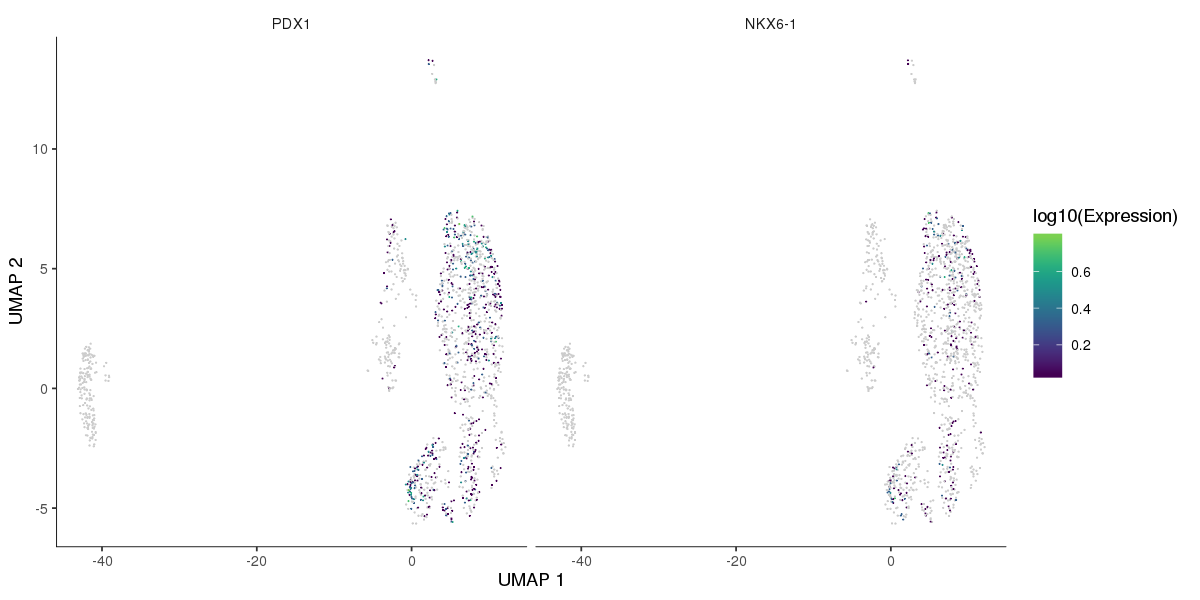

In [18]:
options(repr.plot.width =10, repr.plot.height = 5)
plot_cells(cds, 
           genes=c("PDX1", "NKX6-1"), 
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

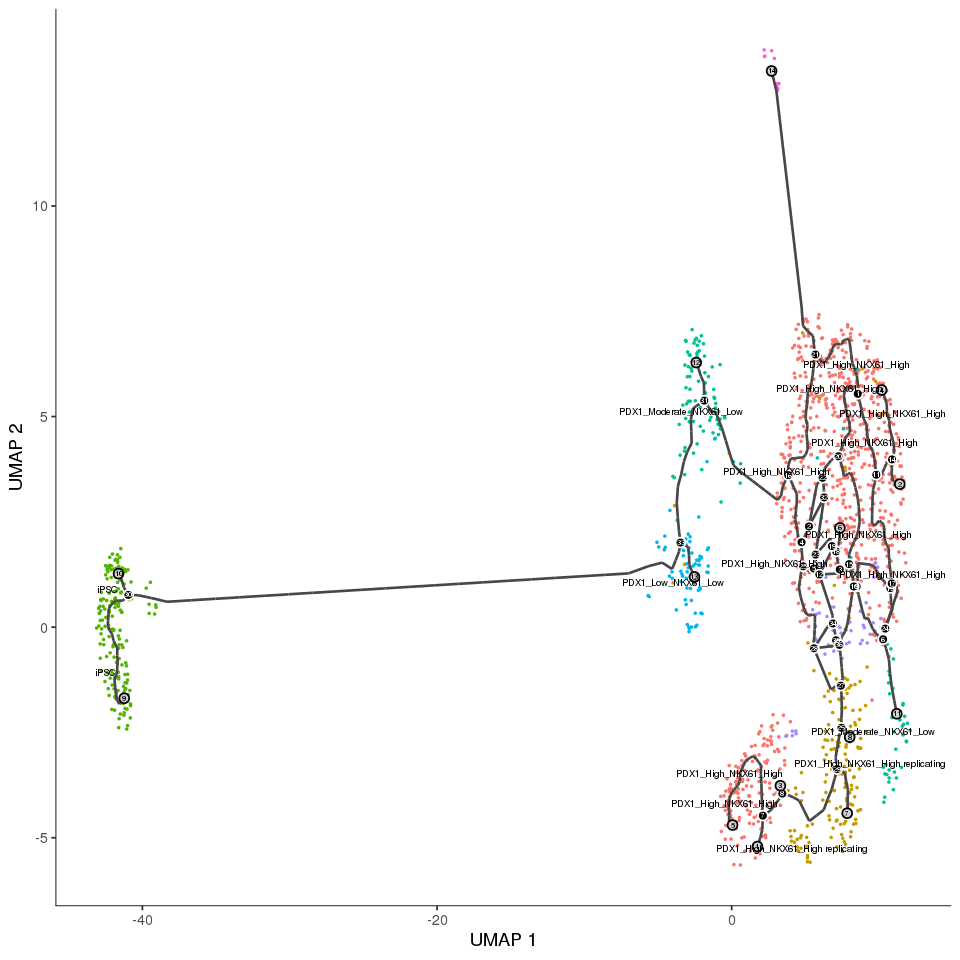

In [19]:
options(repr.plot.width =8, repr.plot.height = 8)

plot_cells(cds, 
           color_cells_by = "Celltype", 
           label_cell_groups=TRUE, 
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

# plot_cells(cds, 
#            color_cells_by = "sample_name", 
#            label_cell_groups=TRUE, 
#            label_leaves=TRUE,
#            label_branch_points=TRUE,
#            graph_label_size=1.5)

# plot_cells(cds, 
#            color_cells_by = "RNA_snn_res.0.5", 
#            label_cell_groups=TRUE, 
#            label_leaves=TRUE,
#            label_branch_points=TRUE,
#            graph_label_size=1.5)

# options(repr.plot.width = 5, repr.plot.height = 5)
# plot_cells(cds, 
#            color_cells_by = "partition", 
#            label_cell_groups=FALSE, 
#            label_leaves=TRUE,
#            label_branch_points=TRUE,
#            graph_label_size=1.5)

In [20]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, cell_phenotype, root_type){

    cell_ids <- which(pData(cds)[, cell_phenotype] == root_type)


    closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
    closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
    root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]

    root_pr_nodes
}


In [21]:
get_earliest_principal_node(cds, "Celltype", "iPSC")

[1] "Y_382"

In [22]:
cds = order_cells(cds, root_pr_nodes = get_earliest_principal_node(cds, "Celltype", "iPSC"))

# pData(cds)$Pseudotime_updated <- max(pData(cds)$pseudotime) - pData(cds)$pseudotime



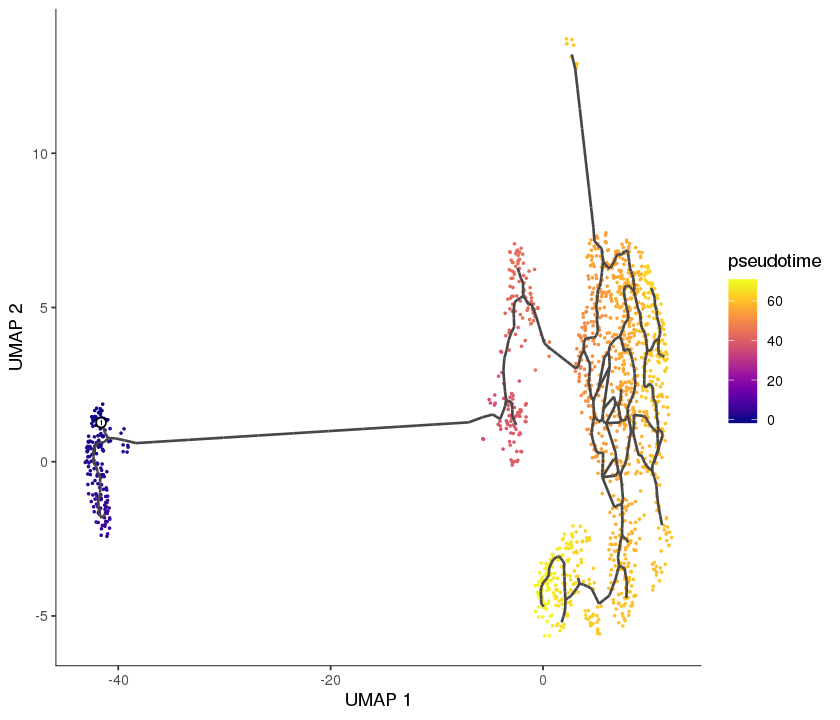

In [23]:
options(repr.plot.width =7, repr.plot.height = 6)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

In [24]:
genes = c("PDX1", "NKX6-1", "CHGA")

lineage_cds = cds[rowData(cds)$gene_short_name %in% genes,]

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

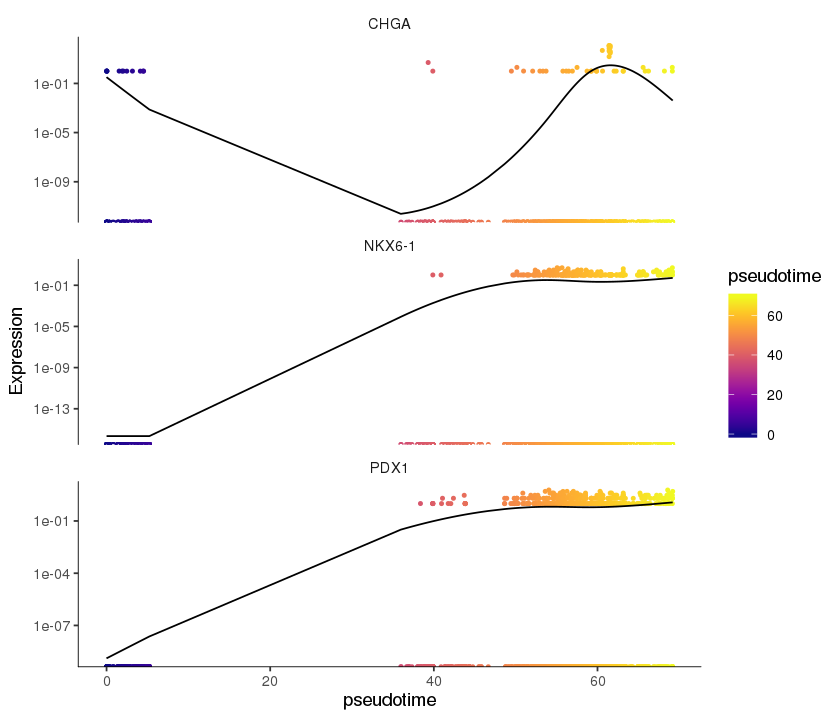

In [25]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="pseudotime")

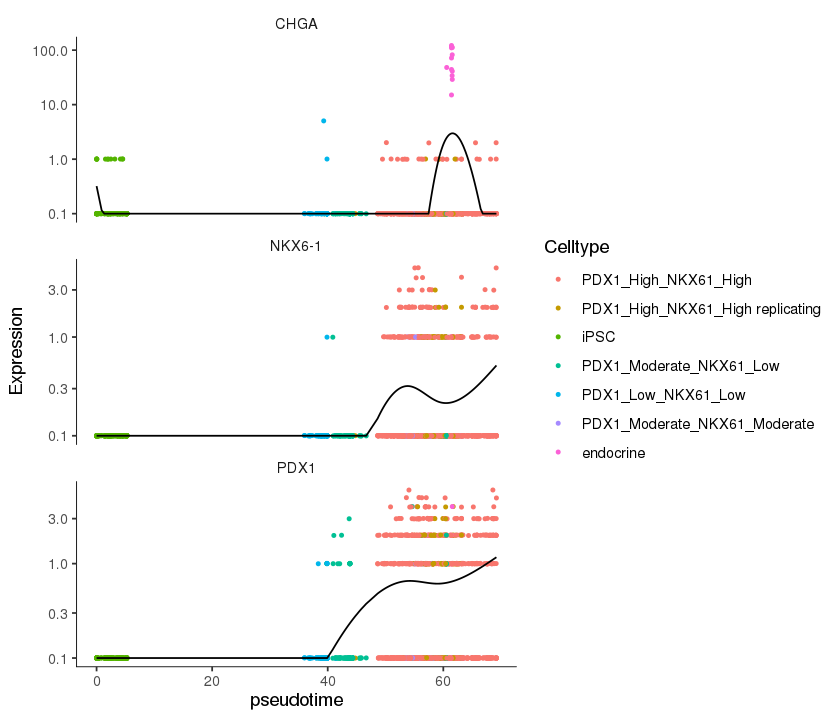

In [26]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="Celltype",
                         min_expr=0.1)